In [58]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import seaborn as sns
from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy.cosmology import WMAP9 as cosmo
import astropy.constants as const
from scipy.stats import permutation_test
import kcorrect.kcorrect
from astroquery.sdss import SDSS
import matplotlib.gridspec as gridspec


plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Times"],
    "text.latex.preamble": r"\usepackage{amsmath}\usepackage{mathptmx}",  # Times Roman
    "hatch.linewidth": 3.0,
})
sns.set_context("paper",font_scale=1.5)
sns.set_palette("pastel")

# get data

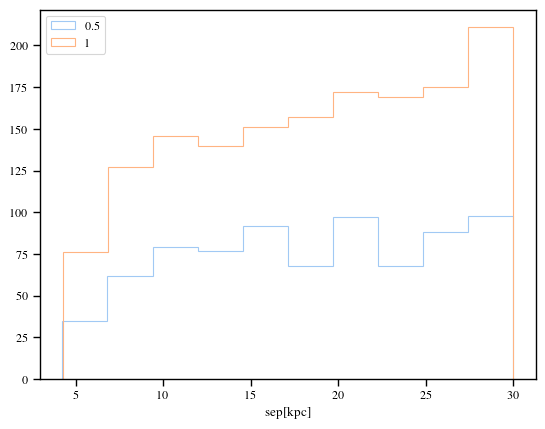

In [52]:
with open("/home/insepien/research-data/df/volonteri22_header.txt", "r") as f:
    d = f.readlines()

colnames = [x[24:34].split()[0] for x in d]
pure05 = pd.read_csv("/home/insepien/research-data/df/volonteri22_z05_30kpc.txt", delim_whitespace=True, names=colnames)
pure1 = pd.read_csv("/home/insepien/research-data/df/volonteri22_z1_30kpc.txt", delim_whitespace=True, names=colnames)
#pure0 = pd.read_csv("/home/insepien/research-data/df/volonteri22_z0.txt", delim_whitespace=True, names=colnames)

def calsep(cat):
    return np.sqrt((cat.x1-cat.x2)**2+(cat.y1-cat.y2)**2+(cat.z1-cat.z2)**2)

pure05['sep'] = calsep(pure05)
pure1['sep'] = calsep(pure1)
#pure0['sep'] = calsep(pure0)

allbh = pd.concat([pure05,pure1])

# plt.hist(pure0.sep,label='0')
plt.hist(pure05.sep,label="0.5",histtype='step')
plt.hist(pure1.sep,label='1',histtype='step')
plt.xlabel("sep[kpc]")
plt.legend();

# measure df

In [22]:
def quart_mask(quant,cuts,ismag=False):
    mask = []
    mask.append(quant<cuts[0])
    if len(cuts)!= 1:
        for i in range(len(cuts)-1):
            mask.append( ( (quant>cuts[i]) & (quant<cuts[i+1]) ) )
    mask.append(quant>cuts[-1])
    if ismag:
        return list(reversed(mask))
    else:
        return mask

def med_diff(rsmall_e,rsmall_l,rbig_e,rbig_l,axis):
    diffbigM = np.median(rbig_e,axis=axis) - np.median(rbig_l,axis=axis)
    diffsmallM = np.median(rsmall_e,axis=axis) - np.median(rsmall_l,axis=axis)
    return diffbigM - diffsmallM


def plot_meh(df_rp,df_z,mass,smallE,smallL,bigE,bigL):
    bigc = 'darkgreen'
    smallc = 'cornflowerblue'

    fig = plt.figure(figsize=(10, 6))
    gs = gridspec.GridSpec(4, 3, figure=fig, width_ratios=[2,2.5,1],height_ratios=[0.5,2.5,2.5,0.5])

    # make axes
    ax_hb = fig.add_subplot(gs[1, 0])
    ax_hs = fig.add_subplot(gs[2, 0])
    ax_scat = fig.add_subplot(gs[2:, 1]) 
    ax_histz = fig.add_subplot(gs[1,1])
    ax_histM = fig.add_subplot(gs[2:,2])

    # plot histograms and median lines
    binz = np.arange(40, np.ceil(np.max(df_rp[bigE]))*10+10,5)/10
    ax_hb.hist(df_rp[bigL],label='bigL',alpha=0.5,color=bigc,bins=binz)
    ax_hb.hist(df_rp[bigE],histtype='step',label='bigE',color=bigc,bins=binz)
    ax_hs.hist(df_rp[smallL],label='smallL',alpha=0.5,color=smallc,bins=binz)
    ax_hs.hist(df_rp[smallE],histtype='step',label='smallE',color=smallc,bins=binz)
    for x,l,ls,c,a in zip([smallE,smallL,bigE,bigL],['smallE', 'smallL', 'bigE', 'bigL'],[":","-",":","-"],[smallc,smallc,bigc,bigc],[ax_hs,ax_hs,ax_hb,ax_hb]):
        a.axvline(np.median(df_rp[x]),label=l,linestyle=ls,color=c)
    # labels
    ax_hs.set_xlim(ax_hb.get_xlim())
    [a.set_xlabel('Sep [kpc]') for a in [ax_hb,ax_hs]]

    # scatter M vs z
    # ax_scat.scatter(df_z, mass,c='k',s=2,alpha=0.4)
    im = [ax_scat.scatter(df_z[mask], mass[mask],c=df_rp[mask]) for mask in [smallE,bigE,smallL,bigL]]
    # labels
    ax_scat.set_xlabel("Z")
    ax_scat.yaxis.set_inverted(True)
    ax_scat.set_xlim(0,np.max(df_z)+0.01)
    ax_scat.set_ylim(np.max(mass)+0.5,np.min(mass)-0.5)

    # histograms along scatter plot
    ax_histz.hist(df_z, color='k',histtype='step')
    ax_histM.hist(mass,orientation='horizontal',color='k',histtype='step')
    ax_histz.set_xlim(ax_scat.get_xlim())
    ax_histM.set_ylim(ax_scat.get_ylim())

    # plot cuts
    [[a.axhline(c,c=clr,alpha=0.5) for c,clr in zip([cutsE[0],cutsE[1]],['g','b'])] for a in  [ax_scat,ax_histM]]

    # colorbar
    fig.colorbar(im[0], ax=ax_histM)
    [a.legend(fontsize=8) for a in [ax_hb,ax_hs,ax_scat]]
    fig.tight_layout();

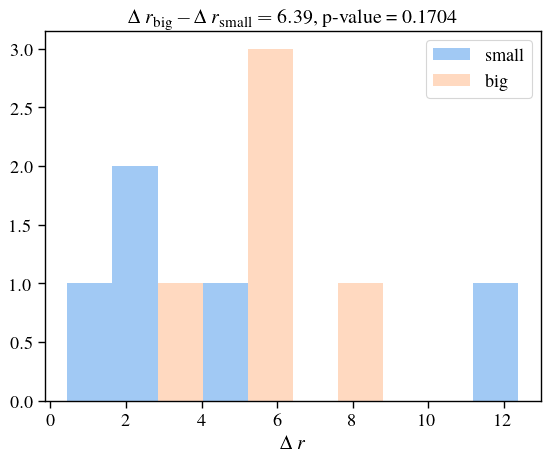

In [62]:
# match IDBH1
matchbh1 = allbh[allbh['IDBH1'].duplicated(keep=False)]
# match IDBH2
fulldf = matchbh1[matchbh1.IDBH2.duplicated(keep=False)].copy()
# calculate how much pair moved btw snapshots
fulldf.sort_values(["IDBH1",'z'],inplace=True)
# remove pairs that grow further apart at low z
pairid = np.sort(list(set(fulldf.IDBH1)))
delr = []
for i in pairid:
    pair = fulldf[fulldf.IDBH1==i]
    delr.extend([np.diff(pair.sep)[0],np.diff(pair.sep)[0]])
fulldf['delr']= delr
# select higher mass BH for cuts
fulldf['mbhp'] = np.array([np.max([i,j]) for i,j in zip(fulldf.logMBH1.values,fulldf.logMBH2.values)])
fulldf['mbhs'] = np.array([np.min([i,j]) for i,j in zip(fulldf.logMBH1.values,fulldf.logMBH2.values)])

# remove pairs that move further apart
finaldf = fulldf[fulldf.delr > 0].copy()
# do sep test
def get_masks(fulldf,smallM=7.5,bigM=8):
    # extract some quantities
    redshifts = fulldf.z.values

    # z masks
    early = redshifts == np.max(fulldf.z)
    late = redshifts == np.min(fulldf.z)

    # mass cut
    smallE = (fulldf.mbhp < smallM) & early
    bigE = (fulldf.mbhp > bigM) & early
    small_ids = fulldf[smallE].IDBH1
    big_ids = fulldf[bigE].IDBH1
    smallL = fulldf.IDBH1.isin(small_ids) & late
    bigL = fulldf.IDBH1.isin(big_ids) & late
    return smallE,smallL,bigE,bigL

smallE,smallL,bigE,bigL = get_masks(finaldf,7.5,8)
seps = [finaldf.sep[m] for m in [smallE,smallL,bigE,bigL]]
test = permutation_test(seps, statistic=med_diff, vectorized=True,alternative='greater')

# plt.figure(dpi=300)
_,b,_ = plt.hist(finaldf[smallE].delr,label='small')
plt.hist(finaldf[bigE].delr,alpha=0.5,bins=b,label='big')
plt.xlabel("$\Delta~ r$")
plt.title(rf"$\Delta~r_{{\rm big}} - \Delta~r_{{\rm small}} = {test.statistic:.2f}$, p-value = {test.pvalue}")
plt.legend();


look at pairs that grew apart. They don't seem weird?

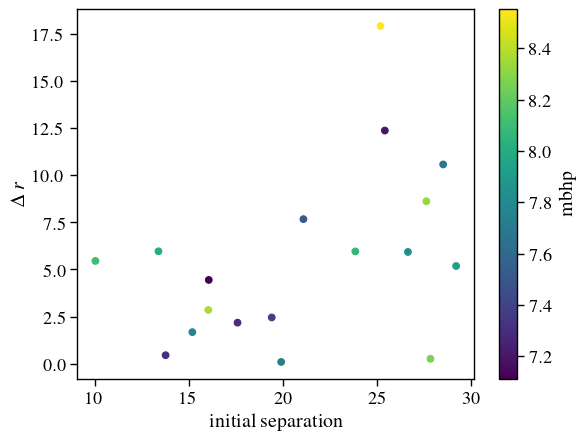

In [61]:
# plt.figure(dpi=300)
plt.scatter(finaldf[finaldf.z==np.max(finaldf.z)].sep, finaldf[finaldf.z==np.max(finaldf.z)].delr,c=finaldf[finaldf.z==np.max(finaldf.z)].mbhp)
# plt.scatter(finaldf[finaldf.z==np.max(finaldf.z)].mbh, finaldf[finaldf.z==np.max(finaldf.z)].delr)
plt.xlabel("initial separation")
plt.ylabel("$\Delta~r$")
plt.colorbar(label='mbhp');

In [31]:
finaldf[smallE][['IDBH2','z','mbhp','mbhs','logMGAL1','logMGAL2','fedd1','fedd2','sep','delr']]

,IDBH2,z,mbhp,mbhs,logMGAL1,logMGAL2,fedd1,fedd2,sep,delr
738,59902,1.0275,7.38131,7.12357,9.83604,10.32038,0.194060,0.003956,19.384911,2.453509
487,283734,1.0275,7.31098,5.79755,10.32690,10.32690,1.000000,0.000015,13.743798,0.449157
943,313380,1.0275,7.11245,6.90989,10.24340,10.24340,0.205660,0.000096,16.037792,4.444779
715,408241,1.0275,7.19503,6.43739,10.03828,9.23390,0.020899,0.007093,25.397393,12.376192
1450,253000,1.0275,7.29706,6.60417,9.28973,10.19001,0.016813,0.000807,17.566819,2.175851


In [28]:
finaldf[smallL][['IDBH2','z','mbhp','mbhs','logMGAL1','logMGAL2','fedd1','fedd2','sep','delr']]

,IDBH2,z,mbhp,mbhs,logMGAL1,logMGAL2,fedd1,fedd2,sep,delr
311,59902,0.4524,7.56826,7.38913,10.62494,10.62494,0.020402,0.000048,16.931402,2.453509
207,283734,0.4524,7.34078,7.31665,10.50874,10.50874,0.001280,0.000023,13.294640,0.449157
742,313380,0.4524,7.29341,6.91292,10.47436,10.47436,0.003616,0.000565,11.593013,4.444779
303,408241,0.4524,7.56812,6.81311,10.51531,10.51531,0.000007,0.000030,13.021200,12.376192
651,253000,0.4524,7.30040,7.16918,10.44147,10.44147,0.000426,0.000005,15.390968,2.175851


# old code, not using same BH pairs across snapshot

/tmp/ipykernel_1264/3910510510.py:65: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  [a.legend(fontsize=8) for a in [ax_hb,ax_hs,ax_scat]]


ValueError: each sample in `data` must contain two or more observations along `axis`.

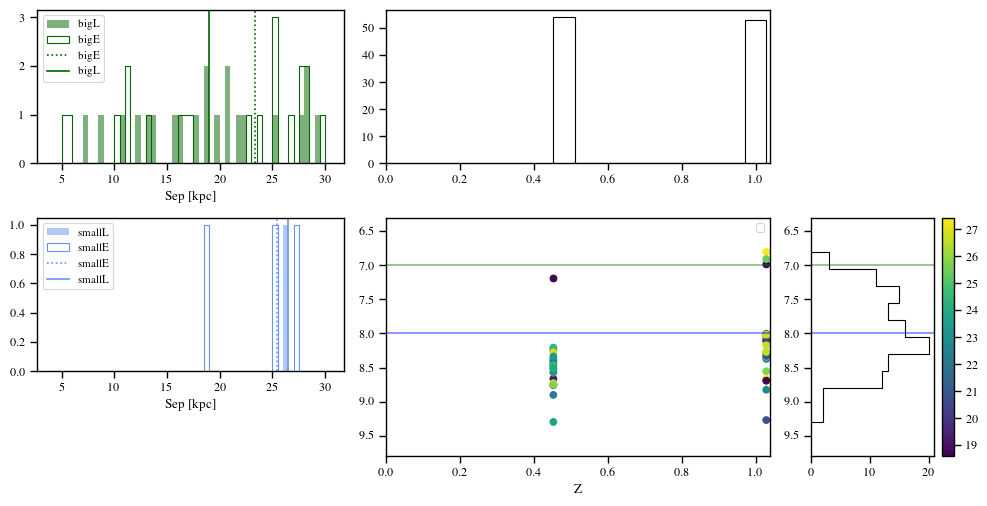

In [45]:
# extract some quantities
mbh = np.array([np.max([i,j]) for i,j in zip(fulldf.logMBH1.values,fulldf.logMBH2.values)])
redshifts = fulldf.z.values
sep = fulldf.sep.values

# z masks
zLate = np.min(fulldf.z)
zEarly = np.max(fulldf.z)
early = redshifts == zEarly
late = redshifts == zLate

# max sep cut
sepcutL = sep < 30#(sep > np.percentile(sep[late],10)) & (sep < np.percentile(sep[late],90)) 
sepcutE = sepcutL  #(sep > np.percentile(sep[early],25)) 

# mass cut
cutsE = np.array([7,8])#np.percentile(mbh,[25,75])
massgain = np.average([np.min(mbh[late]) - np.min(mbh[early]), np.max(mbh[late]) - np.max(mbh[early])])
cutsL = cutsE+massgain
massmaskE= quart_mask(mbh,cutsE)
massmaskL = quart_mask(mbh,cutsL)

# composite masks
smallE = massmaskE[0] & early & sepcutE
smallL = massmaskL[0] & late & sepcutL
bigE = massmaskE[2] & early& sepcutE
bigL = massmaskL[2] & late & sepcutL


plot_meh(fulldf.sep,fulldf.z,mbh,smallE,smallL,bigE,bigL)
seps = [fulldf.sep[m] for m in [smallE,smallL,bigE,bigL]]
print(permutation_test(seps, statistic=med_diff, vectorized=True,alternative='greater'))


/tmp/ipykernel_1817/1593181302.py:3: RuntimeWarning: invalid value encountered in sqrt
  plt.plot(a0, a0-np.sqrt(a0**2 - rhs(1)),label='1 Gyr')
/tmp/ipykernel_1817/1593181302.py:4: RuntimeWarning: invalid value encountered in sqrt
  plt.plot(a0, a0-np.sqrt(a0**2 - rhs(3)),label='3 Gyr')
/tmp/ipykernel_1817/1593181302.py:5: RuntimeWarning: invalid value encountered in sqrt
  plt.plot(a0, a0-np.sqrt(a0**2 - rhs(3)/10),label='3 Gyr, 1e7')
/tmp/ipykernel_1817/1593181302.py:6: RuntimeWarning: invalid value encountered in sqrt
  plt.plot(a0, a0-np.sqrt(a0**2 - rhs(5)),label='5 Gyr')
/tmp/ipykernel_1817/1593181302.py:7: RuntimeWarning: invalid value encountered in sqrt
  plt.plot(a0, a0-np.sqrt(a0**2 - rhs(5)/10),label='5 Gyr, 1e7')


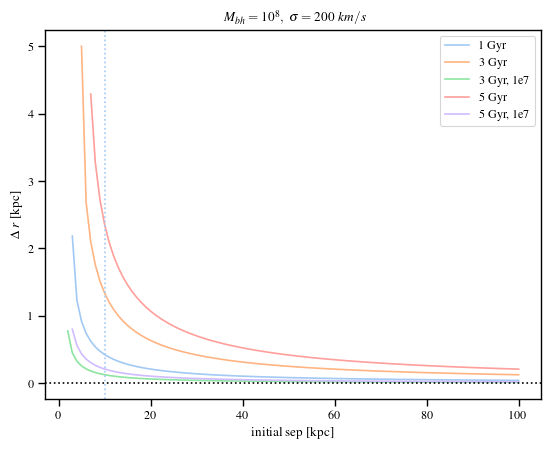

In [22]:
a0 = np.linspace(1,100,100)
rhs = lambda delt: delt*25/3
plt.plot(a0, a0-np.sqrt(a0**2 - rhs(1)),label='1 Gyr')
plt.plot(a0, a0-np.sqrt(a0**2 - rhs(3)),label='3 Gyr')
plt.plot(a0, a0-np.sqrt(a0**2 - rhs(3)/10),label='3 Gyr, 1e7')
plt.plot(a0, a0-np.sqrt(a0**2 - rhs(5)),label='5 Gyr')
plt.plot(a0, a0-np.sqrt(a0**2 - rhs(5)/10),label='5 Gyr, 1e7')
plt.axhline(0,c='k',linestyle=":")
plt.xlabel("initial sep [kpc]")
plt.ylabel("$\Delta~r$ [kpc]")
plt.title("$M_{bh} = 10^8,~\sigma = 200~km/s$")
plt.axvline(10,linestyle=":")
plt.legend();

In [38]:
cosmo.lookback_time(1.5) - cosmo.lookback_time(0.5)

<Quantity 4.32714884 Gyr>

In [44]:
a0 = np.arange(14,30)
rhs = lambda delt: delt*25/3
pd.DataFrame(a0-np.sqrt(a0**2 - rhs(20)),a0)

,0
14,8.583974
15,7.362374
16,6.548369
17,5.939560
18,5.456742
19,5.059651
20,4.724748
21,4.436989
22,4.186148
23,3.964945
